# Proyecto 7

Área: Medio Ambiente

Descripción: Deberán **modelar** el consumo de agua en una ciudad durante varios meses o años, utilizando diferentes variables. El objetivo es **identificar** patrones de uso, **predecir** la demanda futura y **evaluar** posibles escenarios de escasez mediante **simulaciones**.


---

### Librerias importadas

In [134]:
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors 
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')

### Funciones utilizadas

Funciones para calcular estadisticas, diferenciar una serie de tiempo y graficar los resultados:

<Aquí deberia ir separado cada función con una breve explicación de lo que hace>

In [164]:
def diferenciar(serie):
    df_diferenciado = serie.copy()
    df_diferenciado["Consumo"] = serie["Consumo"].diff(periods=12)
    df_diferenciado = df_diferenciado.dropna().reset_index(drop=True)
    return df_diferenciado

def graficar(serie):
    df_temp = serie.copy().set_index('Fecha')
    df_temp.plot()

def calcular_estadisticas(serie):
    df_estadisticas = serie.copy()
    df_estadisticas['Año'] = df_estadisticas['Fecha'].dt.year
    estadisticas = df_estadisticas.groupby('Año')['Consumo'].agg([
    'mean',       # media
    'std',        # desviación estándar
    ])
    display(estadisticas)
    estadisticas[['mean', 'std']].plot(title='Media y desviación estándar por año')
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show()

def periodograma(serie):
    temp = serie["Consumo"]
    valores = temp.values
    n = len(valores)

    frecuencias = np.fft.fftfreq(n, d=1)  
    espectro = np.fft.fft(valores)
    potencia = np.abs(espectro) ** 2

    positivas = frecuencias > 0

    plt.plot(frecuencias[positivas], potencia[positivas])
    plt.title("Espectro de Potencia (FFT)")
    plt.xlabel("Frecuencia (ciclos por unidad de tiempo)")
    plt.ylabel("Potencia")
    plt.grid(True)
    plt.show()



Funciones para calcular reazagos utilizados para la ACF (función de autocorrelación):

<Aquí deberia ir separado cada función con una breve explicación de lo que hace>

In [163]:
def calcular_n_rezagos(serie):
    return int(len(serie) / 4)

def numerador_rk(serie, promedio,k):
    T = len(serie)
    suma = 0
    
    for t in range(k+1, T):
        suma += (serie[t] - promedio) * (serie[t - k] - promedio)
    return suma


def denominador_rk(serie, promedio):
    T = len(serie)
    suma = 0

    for t in range(1, T):
        suma += (serie[t] - promedio)**2
    return suma

def coeficientes_rk(serie):
    n_rezagos = calcular_n_rezagos(serie)
    promedio = serie["Consumo"].sum() / len(serie)
    
    denominador = denominador_rk(serie["Consumo"].values, promedio)

    r = np.empty(n_rezagos, dtype=float)
    for k in range (0 , n_rezagos):
        numerador = numerador_rk(serie["Consumo"].values, promedio, k)
        r[k] = numerador/denominador

    graficar_coeficientes_rk(serie, r)
    return r

def graficar_coeficientes_rk(serie, rk):
    n = len(serie)
    k_vals = np.arange(len(rk)) 

    plt.figure(figsize=(10, 5))
    plt.stem(k_vals, rk, basefmt=" ")
    plt.axhline(0, color='black', linewidth=1)
    plt.title("Correlograma Muestral (ACF)")
    plt.xlabel("Rezago (k)")
    plt.ylabel("rk")
    plt.xticks(k_vals)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Funciones para la parte de PACF

<>

In [176]:
def calcular_yt(serie):
    promedio = serie['Consumo'].mean()
    n_datos = len(serie)

    y = np.empty(n_datos, dtype=float)

    for t in range(0, n_datos):
        y[t] = serie['Consumo'].iloc[t] - promedio
    
    return y      


---

## Análisis del dataset

Analizamos las columnas del data set, de esto posteriormente nos interezará conocer cuantos valores NaN (Not a Number) tenemos y en que columnas.

In [137]:
aguah = pd.read_csv("./AguaH.csv")
aguah.head()

,USO2013,TU,DC,M,UL,f.1_ENE_09,f.1_FEB_09,f.1_MAR_09,f.1_ABR_09,f.1_MAY_09,...,f.1_MAR_15,f.1_ABR_15,f.1_MAY_15,f.1_JUN_15,f.1_JUL_15,f.1_AGO_15,f.1_SEP_15,f.1_OCT_15,f.1_NOV_15,f.1_DIC_15
0,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,197.0,20.0,20.0,20.0,20.0,20.0,...,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,307.0,NaN,30.0,30.0,30.0,30.0,...,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,H3,DOMESTICO RESIDENCIAL,0.5,MSDELAUNET,179.0,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,H3,DOMESTICO MEDIO,0.5,CICASA MMD-15 S,852.0,NaN,NaN,NaN,NaN,NaN,...,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,H3,DOMESTICO RESIDENCIAL,0.5,NaN,NaN,20.0,20.0,20.0,20.0,20.0,...,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


In [138]:
lookup = {'ENE':'01',
          'FEB':'02',
          'MAR':'03',
          'ABR':'04',
          'MAY':'05',
          'JUN':'06',
          'JUL':'07',
          'AGO':'08',
          'SEP':'09',
          'OCT':'10',
          'NOV':'11',
          'DIC':'12'
          }
clist=[]
for col in aguah.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]])

columns = ['TIPO USO','TIPO USUARIO','DIAMETRO_TUBERIA','PROVEEDOR','ENE16']+clist
aguah.columns=columns
aguah.head()

,TIPO USO,TIPO USUARIO,DIAMETRO_TUBERIA,PROVEEDOR,ENE16,2009-01,2009-02,2009-03,2009-04,2009-05,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,197.0,20.0,20.0,20.0,20.0,20.0,...,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,307.0,NaN,30.0,30.0,30.0,30.0,...,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,H3,DOMESTICO RESIDENCIAL,0.5,MSDELAUNET,179.0,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,H3,DOMESTICO MEDIO,0.5,CICASA MMD-15 S,852.0,NaN,NaN,NaN,NaN,NaN,...,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,H3,DOMESTICO RESIDENCIAL,0.5,NaN,NaN,20.0,20.0,20.0,20.0,20.0,...,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


### Datos nulos (NaN)

Identificamos los valores diferentes de NaN, mismos que nos serviran para imputar los datos NaN posteriormente:

Proporción de valores distintos de NaN : 79.06%


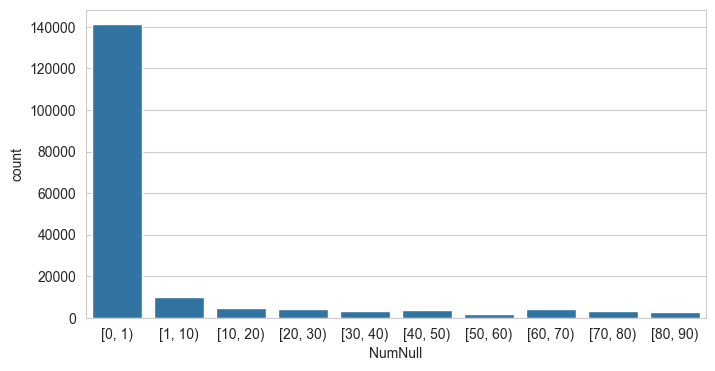

In [139]:
cons = aguah.iloc[0:, 5:]
cons['NumNull'] = cons.isnull().sum(axis=1)
print('Proporción de valores distintos de NaN : {:.2f}%'.format(len(cons[cons.NumNull==0])/len(cons)*100))
bins = [0,1,10,20,30,40,50,60,70,80,90]
cut = pd.cut(cons.NumNull, bins=bins, include_lowest=True, right=False)
fig, axis1 = plt.subplots(1,figsize=(8,4))
sns.countplot(x=cut, data=cut.to_frame(), ax=axis1)
plt.show()

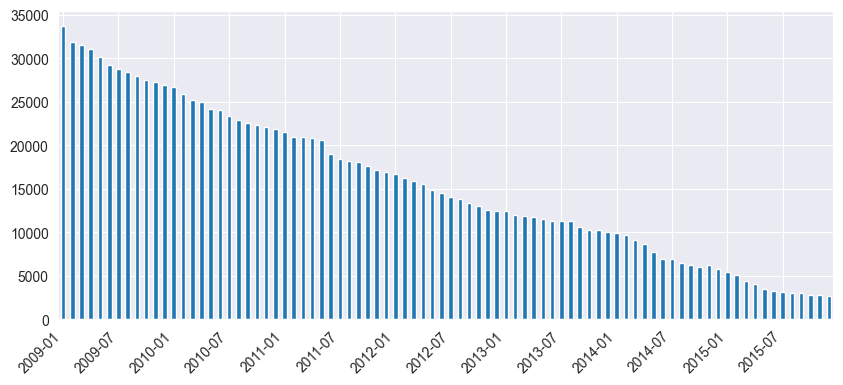

In [140]:
NumNullwithTime = cons.drop('NumNull', axis=1).isnull().sum()

sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
pbar = NumNullwithTime.plot.bar()
plt.xticks(list(range(0,len(NumNullwithTime.index),6)), list(NumNullwithTime.index[0::6]), rotation=45, ha='right')
plt.show()

### Imputación de datos faltantes


* **Intento con SimpleImputer**

In [141]:
from sklearn.impute import SimpleImputer

In [142]:

data = aguah.iloc[0:, 5:]

imputer = SimpleImputer(strategy='mean')

imputed_array = imputer.fit_transform(data)


df_imputed = pd.DataFrame(imputed_array, columns=data.columns)


df_imputed.to_csv('datos_imputados.csv', index=False)
print('Proceso de Imputación terminado')

Proceso de Imputación terminado


## Análisis de los datos Imputados

Con los datos imputados, graficamos el consumo con respecto al tiempo.

* **Serie de tiempo**

In [143]:
df_datos_imputados = pd.read_csv('./datos_imputados.csv')

In [144]:
df_long = df_datos_imputados.melt(var_name='Fecha', value_name='Consumo')
df_long = df_long.groupby('Fecha')['Consumo'].sum().reset_index()
df_consumo_total = df_long.copy()
df_consumo_total['Fecha'] = pd.to_datetime(df_consumo_total['Fecha'])
df_consumo_total

,Fecha,Consumo
0,2009-01-01,1.156379e+07
1,2009-02-01,8.550169e+06
2,2009-03-01,6.758467e+06
3,2009-04-01,7.445560e+06
4,2009-05-01,8.257061e+06
...,...,...
79,2015-08-01,1.810500e+07
80,2015-09-01,1.986351e+07
81,2015-10-01,1.109785e+07
82,2015-11-01,1.541973e+07


<Axes: title={'center': 'Serie de Consumo Total por Fecha'}, xlabel='Fecha'>

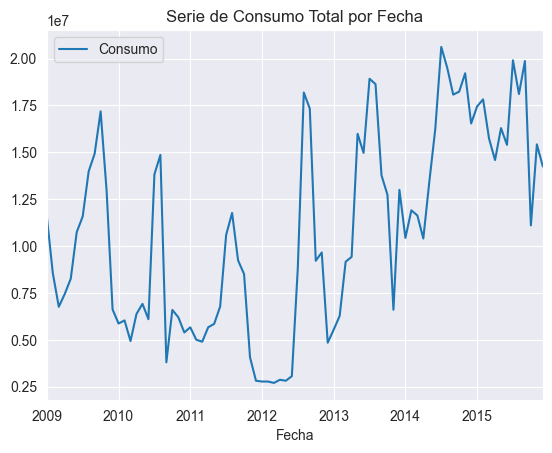

In [145]:
df_temp = df_consumo_total.copy().set_index('Fecha')
df_temp.plot(title="Serie de Consumo Total por Fecha")


El consumo de agua aumenta con el paso del tiempo del 2009 al 2015 el consumo muestra una tendencia ascendente, aunque también se presentan caidas en periodos intermedios.
Un aspecto importante a considerar es la variabilidad, algunos periodos muestra caídas muy bruscas y repidaente se recuperan, siendo una muy clara muestra que el consumo no es constante si no que fluctua


,mean,std
Año,,
2009,1.087858e+07,3.440619e+06
2010,7.240108e+06,3.423263e+06
2011,6.734933e+06,2.721587e+06
2012,7.089517e+06,5.690111e+06
2013,1.208259e+07,4.666698e+06
2014,1.551782e+07,3.761495e+06
2015,1.632464e+07,2.499876e+06


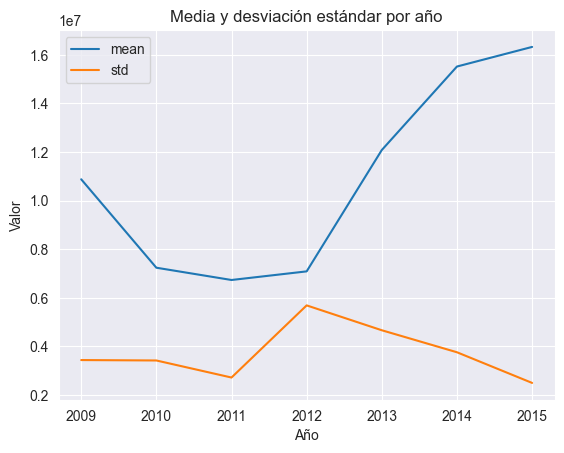

In [146]:
calcular_estadisticas(df_consumo_total)

Saco el ACF del consumo total para identificar una estacionalidad, se supone que como despues del descenso de los coeficientes ACF del consumo actual sigue un pico en 12, entonces respalda la hipótesis de que la estacionalidad está en 12 meses

C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\783694364.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


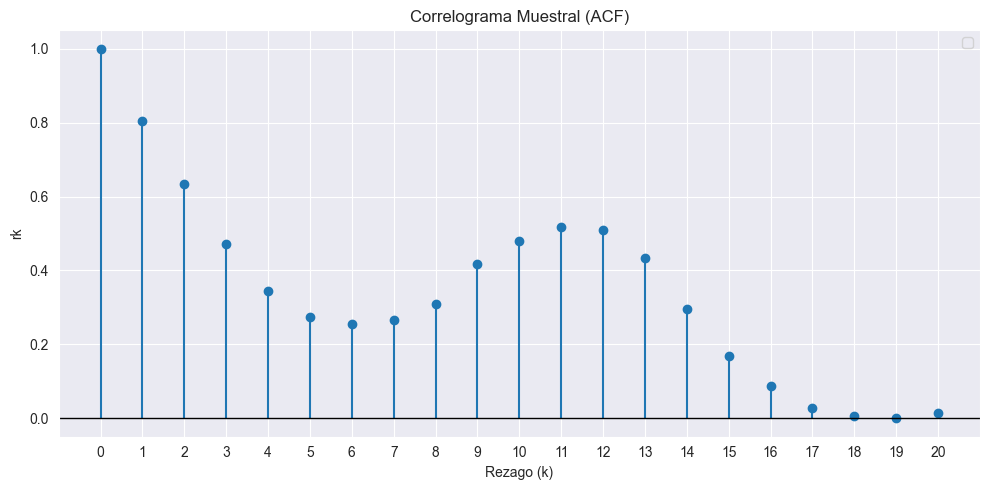

array([ 1.00000000e+00,  8.03445244e-01,  6.33467383e-01,  4.70913588e-01,
        3.42992277e-01,  2.72562922e-01,  2.54497368e-01,  2.65025706e-01,
        3.10131338e-01,  4.17023973e-01,  4.78879533e-01,  5.16572208e-01,
        5.08252081e-01,  4.32215667e-01,  2.95175735e-01,  1.66908110e-01,
        8.74081623e-02,  2.83695206e-02,  4.78944696e-03, -6.78479681e-04,
        1.32255066e-02])

In [165]:
coeficientes_rk(df_consumo_total)

## Modelamiento con método Box-Jenkins

In [147]:
df_consumo_total.to_csv("consumo_total.csv", index = True)

,mean,std
Año,,
2010,-3.638467e+06,4.226952e+06
2011,-5.051747e+05,2.422779e+06
2012,3.545837e+05,4.190626e+06
2013,4.993074e+06,5.417568e+06
2014,3.435232e+06,3.734900e+06
2015,8.068184e+05,4.219539e+06


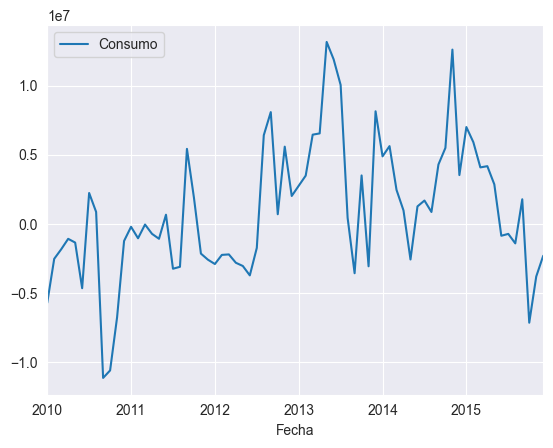

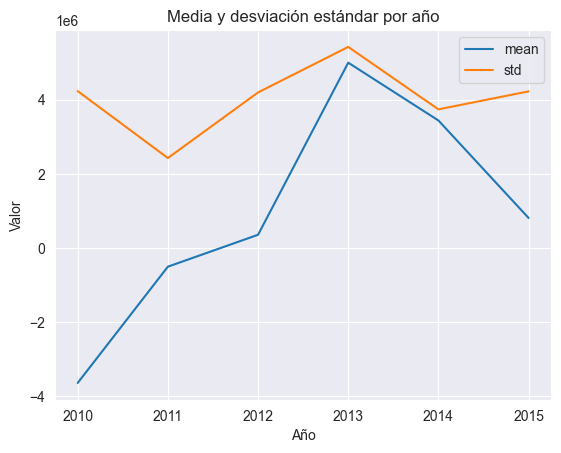

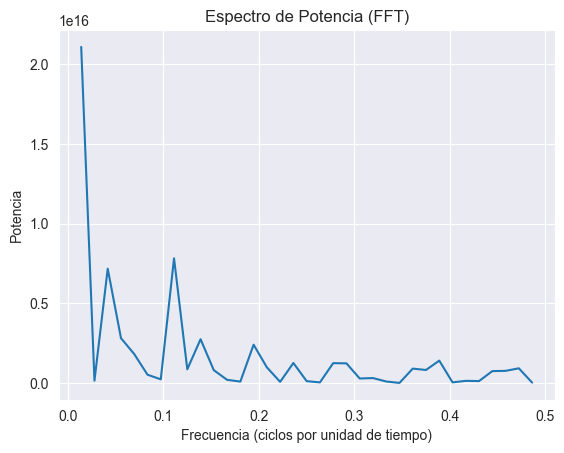

In [148]:
df_dif_1 = diferenciar(df_consumo_total)
graficar(df_dif_1)
calcular_estadisticas(df_dif_1)
periodograma(df_dif_1)

,mean,std
Año,,
2010,-3.638467e+06,4.226952e+06
2011,-5.051747e+05,2.422779e+06
2012,3.545837e+05,4.190626e+06
2013,4.993074e+06,5.417568e+06
2014,3.435232e+06,3.734900e+06
2015,8.068184e+05,4.219539e+06


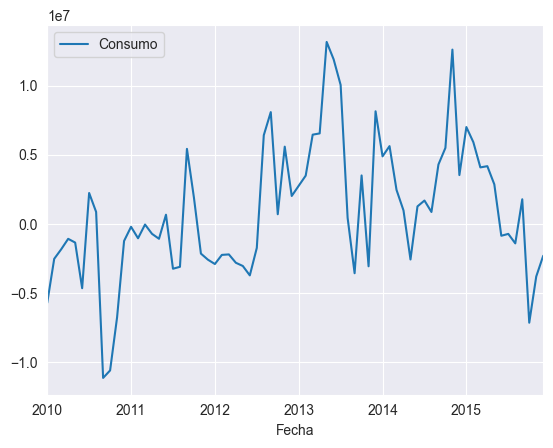

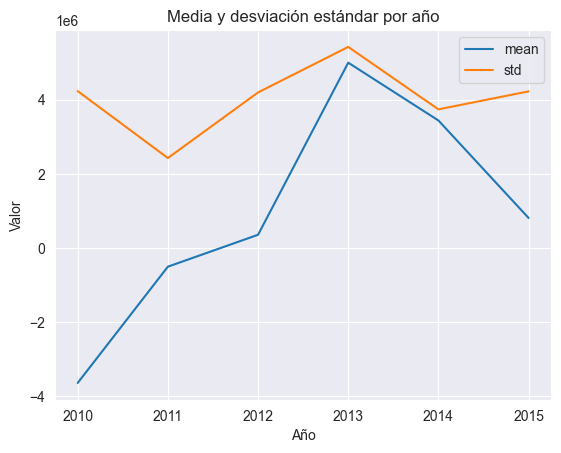

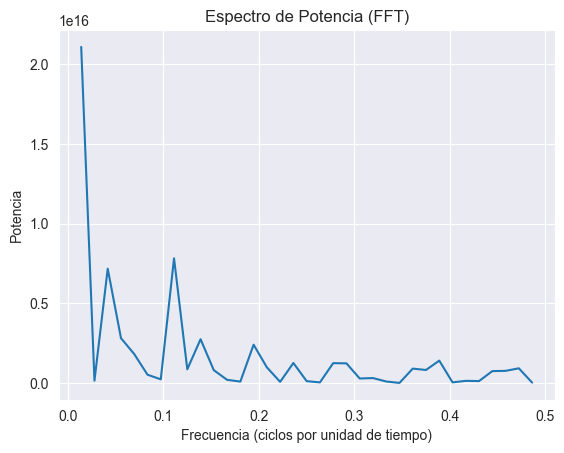

In [149]:
df_dif_2 = diferenciar(df_dif_1)
df_dif_2 = diferenciar(df_consumo_total)
graficar(df_dif_2)
calcular_estadisticas(df_dif_2)
periodograma(df_dif_2)

---

### Experimento usando librerias de python para ACF y PACF

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

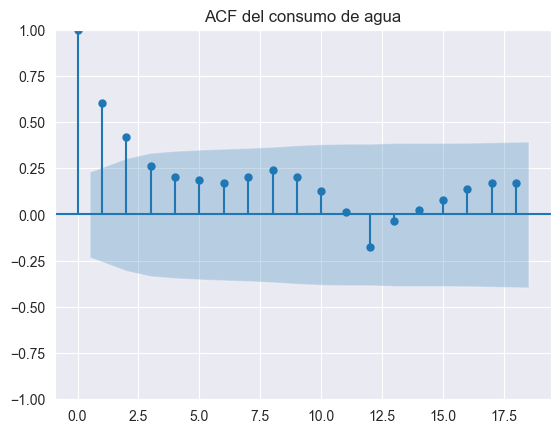

In [ ]:
plot_acf(df_dif_1['Consumo'], lags=18)
plt.title("ACF del consumo de agua")
plt.show()

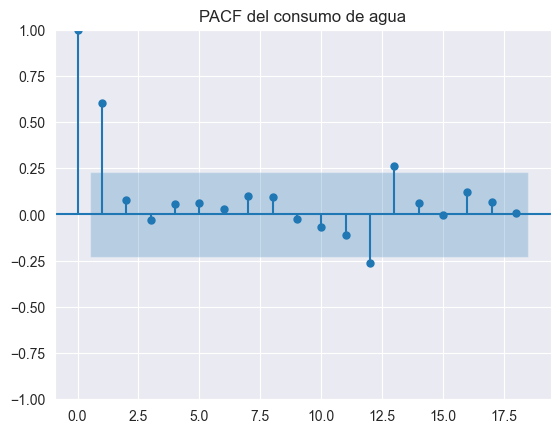

In [152]:
plot_pacf(df_dif_1['Consumo'], lags=18)
plt.title("PACF del consumo de agua")
plt.show()

---

## Función de autocorrelación estimada

La cantidad optima de rezagos a calcular se puede aproximar con:
$$
número de rezagos 
\approx
\frac{número de datos}{4}
$$

$$
número de rezagos 
\approx
\frac{72}{4}
\approx
18
$$

$$
r_k
=
\frac{\sum^T_{t =k+1} (x_t - \hat{x}) (x_{t-k} - \hat{x})}{\sum^T_{t = 1} (x_t - \hat{x})^2}
$$

C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\783694364.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


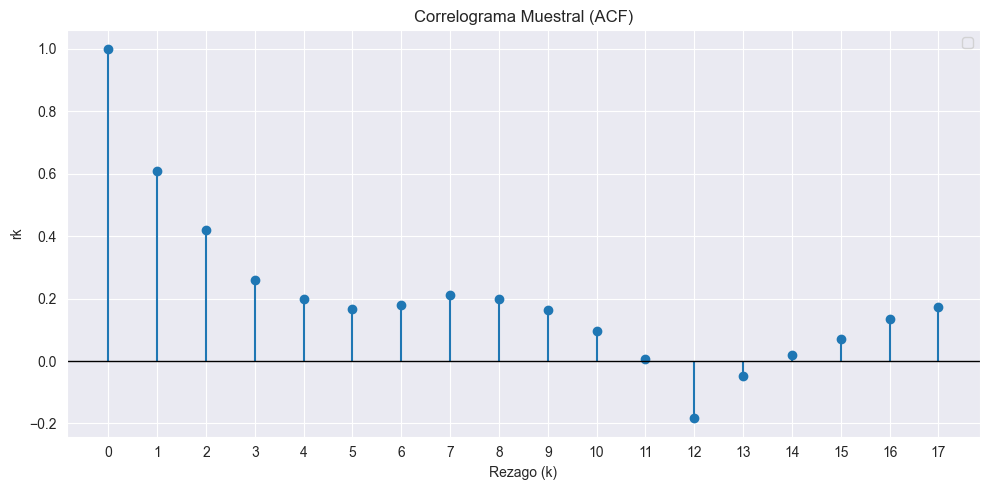

[ 1.          0.60824934  0.41824458  0.2611168   0.19906205  0.16781356
  0.18117224  0.21018566  0.19724238  0.16265622  0.09766674  0.00538395
 -0.18320142 -0.0467366   0.01922269  0.0715328   0.13524808  0.17353303]


In [167]:
rk = coeficientes_rk(df_dif_1)
print(rk)


$$
r_k 
=
\left(
\begin{array}{c}
1.0 \\
0.6082493434988753 \\
0.41824457569429163 \\
0.26111680314354235 \\
0.19906205261224516 \\
0.16781356383140636 \\
0.18117224424582112 \\
0.21018566131384922 \\
0.19724238323856266 \\
0.1626562152243389 \\
0.09766674207526796 \\
0.005383947155139377 \\
-0.18320142462082542 \\
-0.04673659588960856 \\
0.01922269055931879 \\
0.07153280023528318 \\
0.1352480808476952 \\
0.17353303048468904 \\
\end{array}
\right)
$$

---

### Función de autocorrelación parcial estimada

Primer término de la autocorrelación parcial denotado por $\phi_1$ puede estimarse transformando la serie $x_t$ en desviaciones respecto a su medio muestral 
$$
y_t = x_t - \hat{x}
$$
y a continuación estimando una regresión de $y_t$ sobre y $y_{t-1}$, la pendiente estimada de esta regresión es $\phi_1$

In [179]:
y = calcular_yt(df_dif_1)
ut = y[1] - y[0]
print(ut)

3181690.307629728


El primer valor de la función de autocorrelación parcial $\phi_1$ es igual al primer valor de autocorrelación $r_1$, propiedad de las funciones de autocorrelación de todo proceso estocástico
estacionario.

$$
y_t
=
\phi_1 y_{t-1} +
\phi_2 y_{t-2} +
\phi_3 y_{t-3} + \dots
\phi_k y_{t-k} + u_t
$$

---

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose

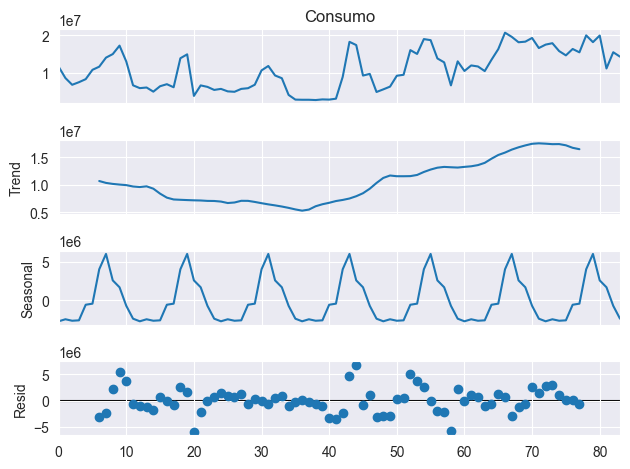

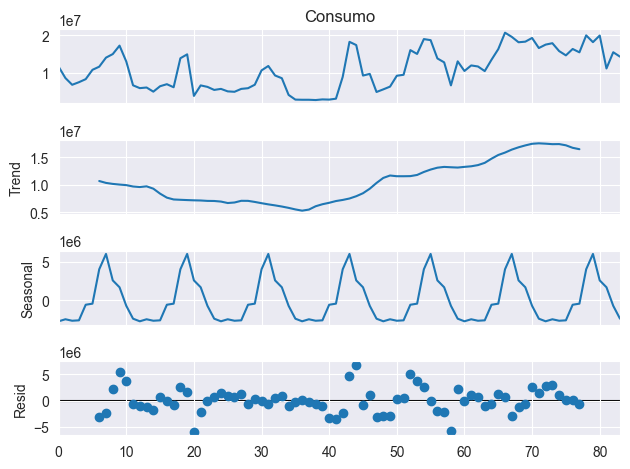

In [156]:
result = seasonal_decompose(df_consumo_total['Consumo'], model='additive', period=12)
result.plot()

In [157]:
from statsmodels.tsa.arima.model import ARIMA

In [158]:
model = ARIMA(df_consumo_total['Consumo'], order=(12,1,2))
result = model.fit()

c:\Users\Sachistein\Proyecto_MN\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [160]:
pronostico = result.forecast(steps=12)
print(pronostico)

84    1.562075e+07
85    1.643302e+07
86    1.512267e+07
87    1.531338e+07
88    1.505102e+07
89    1.750096e+07
90    1.677925e+07
91    1.772185e+07
92    1.587415e+07
93    1.453128e+07
94    1.446093e+07
95    1.526772e+07
Name: predicted_mean, dtype: float64


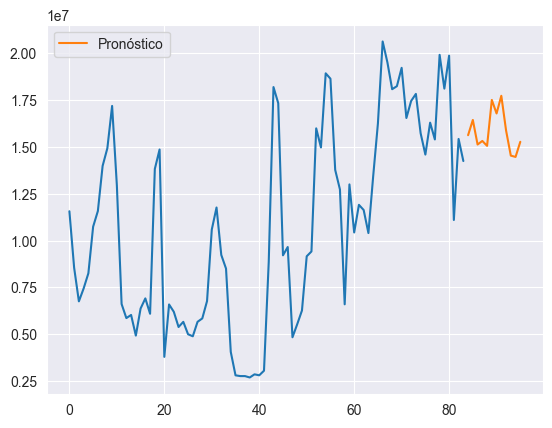

In [161]:
df_consumo_total['Consumo'].plot(label='Histórico')
pronostico.plot(label='Pronóstico', legend=True)
plt.show()

$$
 Y_{t}-\delta_{0}-\delta_{1}t-\ldots-\delta_{k}t^{k}-X_{t}\beta
            =\epsilon_{t} \\
        \left(1-L\right)^{d}\left(1-L^{s}\right)^{D}\Phi\left(L\right)
        \Phi_{s}\left(L\right)\epsilon_{t}
            
        =\Theta\left(L\right)\Theta_{s}\left(L\right)\eta_{t}
$$